This work proposes a classical computer vision pipeline combining SIFT-based Bag-of-Words (BoW) representation and Histogram of Oriented Gradients (HOG) descriptors for multi-class vehicle classification. The fused feature vector is classified using a Linear Support Vector Machine (Linear SVM) with hyperparameter optimization. The goal is to provide a fast, non-deep-learning approach suitable for embedded or low-power environments.


Imports and Utility Functions

In [1]:
import os
import glob
import pickle
import cv2
import numpy as np

from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
from skimage.feature import hog

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


Dataset Loading

In [2]:
def get_sift():
    try:
        return cv2.SIFT_create()
    except:
        return cv2.xfeatures2d.SIFT_create()

def imread_img(path):
    return cv2.imread(path)

def label_image(path):
    labels = [l for l in os.listdir(path) if not l.startswith('.')]
    label2id = {name: i for i, name in enumerate(labels)}
    images, y = [], []

    for label in labels:
        for img_path in glob.glob(os.path.join(path, label, '*')):
            img = imread_img(img_path)
            if img is not None:
                images.append(img)
                y.append(label2id[label])
    return images, y, label2id


SIFT Feature Extraction

In [3]:
def extract_sift_features(images):
    sift = get_sift()
    descriptors = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, des = sift.detectAndCompute(gray, None)
        descriptors.append(des)
    return descriptors


Bag-of-Words Dictionary

In [4]:
def build_bow(all_descriptors, k):
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=5000,
        max_iter=300,
        random_state=42,
        verbose=False
    )
    kmeans.fit(all_descriptors)
    return kmeans.cluster_centers_


Histogram Generation (BoW)

In [5]:
def create_bow_hist(descriptors, bow, k):
    histograms = []

    for desc in descriptors:
        hist = np.zeros(k)
        if desc is not None:
            dist = cdist(desc, bow)
            nearest = np.argmin(dist, axis=1)
            for idx in nearest:
                hist[idx] += 1
        norm = np.linalg.norm(hist)
        if norm > 0:
            hist /= norm
        histograms.append(hist)
    return np.array(histograms)


HOG Feature Extraction

In [6]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 64))
        feat = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            feature_vector=True,
            channel_axis=None
        )
        hog_features.append(feat)
    return np.array(hog_features)


Feature Fusion

In [7]:
DATASET_PATH = "data"
NUM_CLUSTER = 300
MODEL_PATH = "sift_hog_linear_svm.sav"
BOW_PATH = "bow_dictionary.pkl"

images, labels, label2id = label_image(DATASET_PATH)

descriptors = extract_sift_features(images)

all_desc = np.vstack([d for d in descriptors if d is not None])

if os.path.isfile(BOW_PATH):
    bow = pickle.load(open(BOW_PATH, "rb"))
else:
    bow = build_bow(all_desc, NUM_CLUSTER)
    pickle.dump(bow, open(BOW_PATH, "wb"))

X_bow = create_bow_hist(descriptors, bow, NUM_CLUSTER)
X_hog = extract_hog_features(images)

X = np.hstack([X_bow, X_hog])
y = np.array(labels)


Training (Linear SVM + Scaling + GridSearch)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(class_weight='balanced', max_iter=5000))
])

param_grid = {
    'svm__C': [0.1, 0.5, 1, 2, 5]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

pickle.dump(grid.best_estimator_, open(MODEL_PATH, "wb"))

print("Train Accuracy:", grid.score(X_train, y_train))
print("Validation Accuracy:", grid.score(X_val, y_val))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Train Accuracy: 1.0
Validation Accuracy: 0.9750692520775623


Evaluation on Test Set

Test Accuracy: 0.98
              precision    recall  f1-score   support

         bus       1.00      1.00      1.00        10
         car       1.00      1.00      1.00        10
        moto       1.00      0.90      0.95        10
  pedestrian       0.91      1.00      0.95        10
       truck       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



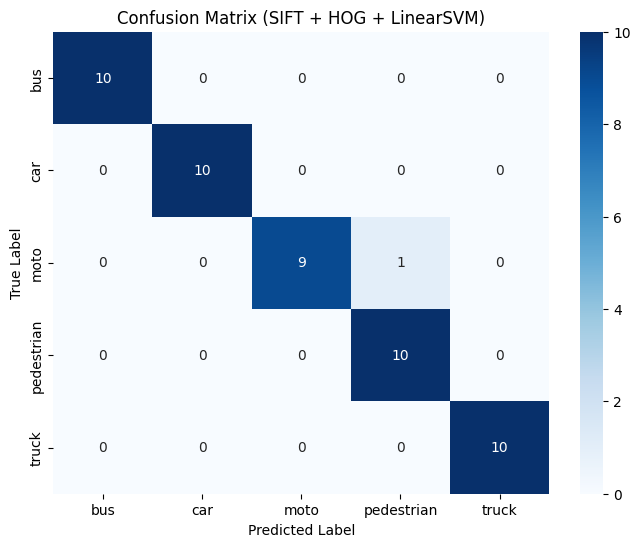

In [12]:
TEST_PATH = "test_data"

test_images, test_labels, _ = label_image(TEST_PATH)

test_desc = extract_sift_features(test_images)
X_bow_test = create_bow_hist(test_desc, bow, NUM_CLUSTER)
X_hog_test = extract_hog_features(test_images)

X_test = np.hstack([X_bow_test, X_hog_test])

model = pickle.load(open(MODEL_PATH, "rb"))

y_pred = model.predict(X_test)

print("Test Accuracy:", accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred, target_names=label2id.keys()))

id2label = {v: k for k, v in label2id.items()}
labels = [id2label[i] for i in sorted(id2label.keys())]

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (SIFT + HOG + LinearSVM)")
plt.show()

